# Quantum benchmark

## I - Introduction

## II - Packages

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import normalize
from sklearn.model_selection import cross_val_score, KFold
#Import classical libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import datasets
import matplotlib.pyplot as plt
from skpp import ProjectionPursuitRegressor

plt.style.use('ggplot')

import functools

from qiskit import BasicAer
from qiskit.circuit.library import ZZFeatureMap
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.datasets import ad_hoc_data
import logging

import pennylane as qml
from pennylane.templates.embeddings import AngleEmbedding, AmplitudeEmbedding
from pennylane.optimize import AdamOptimizer

from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal, ZZFeatureMap
import qiskit

In [5]:
import warnings
warnings.filterwarnings('ignore')

## III - Data 

In [6]:
# Read out CSV

df = pd.read_csv('fraud_detection_bank_dataset.csv', sep=',')

In [82]:
df.columns

Index(['Unnamed: 0', 'col_0', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5',
       'col_6', 'col_7', 'col_8',
       ...
       'col_103', 'col_104', 'col_105', 'col_106', 'col_107', 'col_108',
       'col_109', 'col_110', 'col_111', 'targets'],
      dtype='object', length=114)

In [83]:
df['Unnamed: 0']

0            0
1            1
2            2
3            3
4            4
         ...  
20463    20463
20464    20464
20465    20465
20466    20466
20467    20467
Name: Unnamed: 0, Length: 20468, dtype: int64

In [84]:
df.shape

(20468, 114)

In [3]:
%%script false --no-raise-error

import sweetviz as sv

#EDA using Autoviz
sweet_report = sv.analyze(df)

#Saving results to HTML file
sweet_report.show_html('sweet_report.html')

## IV - Modelisation

### Classical

In [7]:
df = df.drop(['Unnamed: 0'], axis = 1)
df_labels = df['targets']
df.drop(['targets'],axis = 1,inplace = True)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df, df_labels, test_size=0.2, random_state=42)

## Quantum Approaches

In [95]:
np.unique(df_labels)

array([0, 1])

In [9]:
cols = ['col_8', 'col_9', 'col_10', 'col_11', 'col_12', 'col_18', 'col_19','col_20', 'col_21', 'col_35', 
        'col_51', 'col_52', 'col_53', 'col_70','col_71','col_7', 'col_22', 'col_54', 'col_56']

In [10]:
X_train = X_train.drop(cols, axis=1)
X_test = X_test.drop(cols, axis=1)

In [11]:
np.shape(X_train)

(16374, 93)

In [14]:
skpp = ProjectionPursuitRegressor(r=2, fit_type='spline', opt_level='medium').fit(X_train, y_train)

In [15]:
# SKPP validate transformation (using train fit)
x_train_skpp = skpp.transform(X_train)
x_test_skpp = skpp.transform(X_test)

In [16]:
# Arrays to dataframe for join in a single df
x_train_skpp = pd.DataFrame(x_train_skpp)
x_test_skpp = pd.DataFrame(x_test_skpp)

In [22]:
# Second standard scaler normalization (using train fit)
std_scale = StandardScaler().fit(x_train_skpp)
X_train_skpp_norm = std_scale.transform(x_train_skpp)
x_test_skpp_norn = std_scale.transform(x_test_skpp)
#x_validate_lda_n = std_scale.transform(x_validate_skpp)

In [19]:
# Dimensions definition for QML
n_dim = len(x_train_skpp.columns)
n_dim

2

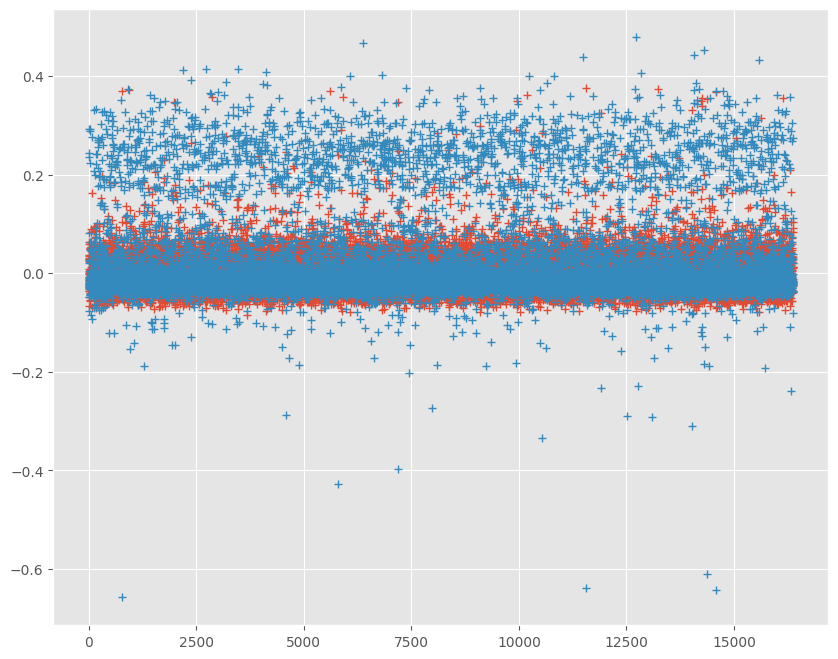

In [20]:
plt.figure(figsize=(10,8))
plt.plot(x_train_skpp, '+')


## Split train test 

In [23]:
# Split dataset into train and test

sample_train, sample_test, label_train, label_test = train_test_split(
     X_train_skpp_norm, y_train, test_size=0.2, random_state=22)

# Normalize

# Select a sample for a better control of the research and wall time

train_size = 800#160
sample_train = sample_train[:train_size]
label_train = label_train[:train_size]

test_size = 200 #40
sample_test = sample_test[:test_size]
label_test = label_test[:test_size]

In [24]:
# Basic parameters for hybrid model

seed = 8500
feature_dim = n_dim
num_reps = 2
num_shots =256 


## Hybrid

In [ ]:
# Define feature_map

feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=num_reps)

# Define the backend
backend = QuantumInstance(
    BasicAer.get_backend("qasm_simulator"), shots=num_shots, seed_simulator=seed, seed_transpiler=seed
)

# Define the kernel

kernel = QuantumKernel(feature_map=feature_map, quantum_instance=backend)

# Model run
svc = SVC(kernel=kernel.evaluate)
svc.fit(sample_train, label_train)
score = svc.score(sample_test, label_test)

print(f"Callable kernel classification test score: {score}")

In [ ]:
result_predict = svc.predict(sample_test)

In [ ]:
print(metrics.classification_report(label_test,result_predict))

In [ ]:
from sklearn.model_selection import cross_validate
def evaluate_ml_model(_models, X, y, n_fold=10, metric='precision'):
    ''' Function to evaluate a ML and QML model with a list of metrics
    
    
    '''
    results = pd.DataFrame()
    kfold = KFold(n_splits=n_fold)
    columns = []
    for name, model in _models:
        # -------------------
        # Variables initialization 
        _df = pd.DataFrame()
        names = []
        means = []
        stds = []
        
        # -------------------
        # k-fold Cross validation
        cv_results = cross_validate(model, X, y, cv=kfold, scoring=metric)
        
        # -------------------
        # Compute the mean and standard deviation 
        for _name, _array in cv_results.items():
            names.append(_name)
            means.append(round(_array.mean(), 5))
            stds.append(round(_array.std(), 5))
        # -------------------
        # Save the results in a dataframe 
        _df =  pd.DataFrame([means, stds], columns=names)
        columns.extend([name+' mean (%)', name+' std (%)'])
        #results = results.join(_df, on=_df.index)
        results = results.append(_df)
    results.index = columns
    print(results)
    return results

In [ ]:
models = []
models.append(('LR', LogisticRegression(max_iter=1000)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('qsvc', svc))
_metrics = ['precision', 'recall', 'f1', 'accuracy',  'matthews_corrcoef','balanced_accuracy']

In [ ]:
df_results = pd.DataFrame()

In [ ]:
df_results = evaluate_ml_model(models, sample_train, label_train, n_fold=10, metric=_metrics)

In [ ]:
df_results

## QSVC

In [ ]:
# Be assure that your qiskit version is 0.4.0
# run !pip install --upgrade qiskit==0.4.0 if not 

In [24]:
#%%script false --no-raise-error
# Define feature_map, optimizer and var_form

feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2)
optimizer = COBYLA(maxiter=20, disp=True, rhobeg=1.0, tol=None)
var_form = TwoLocal(feature_dim, ['ry', 'rz'], 'cz', reps=3)


# Define the backend

#backend = qiskit.Aer.get_backend('qasm_simulator')
backend = BasicAer.get_backend("qasm_simulator")
# Define the instance

quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)

# Model run
vqc = QSVC(quantum_kernel=quantum_instance)#optimizer, feature_map, var_form, training_input, test_input, datapoints[0])


result = vqc.fit(sample_train, label_train)



AttributeError: 'QuantumInstance' object has no attribute 'evaluate'

In [1]:
import qiskit
qiskit.__version__

'0.21.1'

In [33]:
!pip3 install --upgrade qiskit #==0.4.0

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


## Pennylane

In [ ]:
from pennylane import numpy as np

In [ ]:
# Angle Encoding

num_qubits = n_dim

dev = qml.device('default.qubit', wires = num_qubits)

@qml.qnode(dev)
def circuit(parameters, data):
    for i in range(num_qubits):
        qml.Hadamard(wires = i)
    
    AngleEmbedding(features = data, wires = range(num_qubits), rotation = 'Y')
    
    qml.StronglyEntanglingLayers(weights = parameters, wires = range(num_qubits))
    
    return qml.expval(qml.PauliZ(0))

In [ ]:
num_layers = 5
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

#print(weights_init, bias_init)

In [ ]:
circuit(weights_init, sample_train[0])

In [ ]:
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

In [ ]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

In [ ]:
def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

In [ ]:
def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

In [ ]:
pd.Series(label_test).value_counts()

In [ ]:
Y = np.array(label_train * 2 - np.ones(len(label_train)),requires_grad=True)  # shift label from {0, 1} to {-1, 1}
X = np.array(sample_train, requires_grad=True)

for i in range(5):
    print("X = {}, Y = {: d}".format(list(X[i]), int(Y[i])))

In [ ]:
opt = AdamOptimizer(stepsize=0.1, beta1=0.9, beta2=0.99, eps=1e-08)
batch_size = 10

In [ ]:
weights = weights_init
bias = bias_init

wbest = 0
bbest = 0
abest = 0
ccost = 0 
for it in range(150):

    # weights update by one optimizer step

    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, X_batch, Y_batch)

    # Compute the accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]
    
    '''if accuracy(Y, predictions) > abest:
        wbest = weights
        bbest = bias
        abest = accuracy(Y, predictions)
        print('New best')

    acc = accuracy(Y, predictions)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Accuracy: {:0.7f} ".format(
            it + 1, cost(weights, bias, X, Y), acc
        )
    )'''
    prec = metrics.f1_score(Y, predictions, average='binary', pos_label=1)
    if  prec > abest or ((prec == abest) and (cost(weights, bias, X, Y) < ccost)):
        wbest = weights
        bbest = bias
        abest = prec
        ccost = cost(weights, bias, X, Y)
        print('New best')
    #prec = metrics.precision_score(Y, predictions, average='binary')
    print(
        "Iter: {:5d} | Cost: {:0.7f} | f1: {:0.7f} ".format(
            it + 1, cost(weights, bias, X, Y), prec
        )
    )
    
    

In [ ]:
Yte = np.array(label_test * 2 - np.ones(len(label_test)))
Xte = np.array(normalize(sample_test))

In [ ]:
pd.Series(Yte).value_counts()

In [ ]:
predictions = [np.sign(variational_classifier(wbest, bbest, x)) for x in Xte]
pred = [np.sign(variational_classifier(wbest, bbest, x)) for x in X]
acc = accuracy(Yte, predictions)

print(f'Cost: {cost(wbest, bbest, Xte, Yte)}, Accuracy: {np.round(acc, 2) * 100}%')

In [ ]:
print(metrics.classification_report(Yte,predictions))

In [69]:
print(metrics.classification_report(predictions,Yte))

              precision    recall  f1-score   support

        -1.0       1.00      0.82      0.90       187
         1.0       0.28      1.00      0.44        13

    accuracy                           0.83       200
   macro avg       0.64      0.91      0.67       200
weighted avg       0.95      0.83      0.87       200



In [ ]:
print(f'''

    Precision: {round(100*metrics.precision_score(predictions,Yte),2)}%
    Recall: {round(100*metrics.recall_score(predictions,Yte),2)}%
    f1: {round(100*metrics.f1_score(predictions,Yte),2)}%
    Accuracy: {round(100*metrics.accuracy_score(predictions,Yte),2)}%
    Balanced accuracy: {round(100*metrics.balanced_accuracy_score(predictions,Yte),2)}%
    Matthew corcorref: {round(100*metrics.matthews_corrcoef(predictions,Yte),2)}%
    ''')

In [ ]:
_models = []
_models.append(('qsvc',svc))
_metrics = ['precision', 'recall', 'f1', 'accuracy', 'balanced_accuracy', 'matthews_corrcoef']
for metric in _metrics:
    df_results= pd.concat([df_results, evaluate_ml_model(_models, sample_train, label_train, n_fold=10, metric=metric)], axis=1)

In [ ]:
weights = weights_init
bias = bias_init

wbest = 0
bbest = 0
abest = 0
ccost = 1 
for it in range(150):

    # weights update by one optimizer step

    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, X_batch, Y_batch)

    # Compute the accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]
    
    '''if accuracy(Y, predictions) > abest:
        wbest = weights
        bbest = bias
        abest = accuracy(Y, predictions)
        print('New best')

    acc = accuracy(Y, predictions)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Accuracy: {:0.7f} ".format(
            it + 1, cost(weights, bias, X, Y), acc
        )
    )'''
    prec = accuracy(Y, predictions)
    if  prec > abest or ((prec == abest) and (cost(weights, bias, X, Y) < ccost)):
        wbest = weights
        bbest = bias
        abest = prec
        ccost = cost(weights, bias, X, Y)
        print('New best')
    #prec = metrics.precision_score(Y, predictions, average='binary')
    print(
        "Iter: {:5d} | Cost: {:0.7f} | Accuracy: {:0.7f} ".format(
            it + 1, cost(weights, bias, X, Y), prec
        )
    )
    
    

In [ ]:
predictions = [np.sign(variational_classifier(wbest, bbest, x)) for x in Xte]
pred = [np.sign(variational_classifier(wbest, bbest, x)) for x in X]
acc = accuracy(Yte, predictions)

print(f'Cost: {cost(wbest, bbest, Xte, Yte)}, Accuracy: {np.round(acc, 2) * 100}%')

In [ ]:
print(metrics.classification_report(Yte, predictions))

In [ ]:
print(f'''

    Precision: {round(100*metrics.precision_score(predictions,Yte),2)}%
    Recall: {round(100*metrics.recall_score(predictions,Yte),2)}%
    f1: {round(100*metrics.f1_score(predictions,Yte),2)}%
    Accuracy: {round(100*metrics.accuracy_score(predictions,Yte),2)}%
    Balanced accuracy: {round(100*metrics.balanced_accuracy_score(predictions,Yte),2)}%
    Matthew corcorref: {round(100*metrics.matthews_corrcoef(predictions,Yte),2)}%
    ''')